# 필요한 데이터 및 함수들 불러오기

In [ ]:
!pip install basemap
!pip install basemap-data-hires

!pip install ipympl
!pip install nodejs-bin
!jupyter labextension install @jupyter-widgets/jupyterlab-manager
!jupyter labextension install jupyter-matplotlib
!pip install graphviz
!pip install shapely

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 936.0/936.0 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 41.1 MB/s eta 0:00:00
  Attempting uninstall: pyproj
    Found existing installation: pyproj 3.7.0
    Uninstalling pyproj-3.7.0:
      Successfully uninstalled pyproj-3.7.0
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.1/91.1 MB 8.7 MB/s eta 0:00:00


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 MB 15.0 MB/s eta 0:00:00
usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir] [--paths] [--json]
               [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: bundlerextension console dejavu execute kernel kernelsp

In [ ]:
import shapely.geometry
import pandas as pd
import numpy as np
import importlib
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from datetime import datetime
import time
import copy
import math
import IPython
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install import_ipynb
import import_ipynb

%cd '/content/drive/MyDrive/Colab Notebooks/PathRecommendation/'

/content/drive/MyDrive/Colab Notebooks/PathRecommendation


In [ ]:
#실제 ais경로(시각화 및 비교용도)
with open('./files/real_path_lats.pkl', 'rb') as f:
    real_path_lats = pd.read_pickle(f)
with open('./files/real_path_lons.pkl', 'rb') as f:
    real_path_lons = pd.read_pickle(f)

In [ ]:
#3km 그리드 파일 불러오기

with open('./files/grid_lon_3km.pkl', 'rb') as f:   #나눈 그리드의 좌표값
    grid_lon = pd.read_pickle(f)
with open('./files/grid_lat_3km.pkl', 'rb') as f:
    grid_lat = pd.read_pickle(f)

with open('./files/grid_lat_lon_keys_3km.pkl', 'rb') as f:   #육지 제외 그리드의 좌표들
    grid_lat_lon_keys = pd.read_pickle(f)

with open('./files/score_dic_3km.pkl', 'rb') as f:   #스코어파일
    score_dic = pd.read_pickle(f)


#1km 그리드 파일 불러오기
'''
with open('./files/grid_map_1km.pkl', 'rb') as f:
    grid_lon = pd.read_pickle(f)
with open('./files/grid_map_1km.pkl', 'rb') as f:
    grid_lat = pd.read_pickle(f)

with open('l./files/grid_map_1km.pkl', 'rb') as f:
    grid_lat_lon_keys = pd.read_pickle(f)

with open('./files/grid_map_1km.pkl', 'rb') as f:
    score_dic = pd.read_pickle(f)
'''

"\nwith open('./files/grid_map_1km.pkl', 'rb') as f:\n    grid_lon = pd.read_pickle(f)\nwith open('./files/grid_map_1km.pkl', 'rb') as f:\n    grid_lat = pd.read_pickle(f)\n\nwith open('l./files/grid_map_1km.pkl', 'rb') as f:\n    grid_lat_lon_keys = pd.read_pickle(f)\n\nwith open('./files/grid_map_1km.pkl', 'rb') as f:\n    score_dic = pd.read_pickle(f)\n"

# 추천 경로 생성

* score_dic[key] = [트래픽 볼륨, 날씨점수, 혼잡도점수, 트래픽점수, 거리점수, 총점수]

* 안전:효율 비중에 따른 추천 경로 도출

* 총 점수 계산식: score = alpha * (날씨점수 + 트래픽점수) + (1-alpha) * 거리점수

* 총 점수에 지수함수를 적용하여 큰 값을 강조, 위험도 높은 그리드를 경로에서 최대한 배제함

In [ ]:
def score(score_dic, alpha): # 총 점수 계산, score(score_dic, 안전에 대한 가중치)
    for key in score_dic.keys():
        lat, lon = eval(key)
        score_dic[key][5] = np.exp(alpha * (score_dic[key][1] + score_dic[key][3]) + (1 - alpha) * score_dic[key][4])
    return score_dic

In [ ]:
def draw_basemap_grid(lats, lons, m, color):
    x, y = m(lons, lats)
    xy = zip(x, y)
    poly = Polygon(list(xy), facecolor=color, edgecolor='black', lw=0.7, alpha=0.4)
    plt.gca().add_patch(poly)
    return poly

In [ ]:
def draw_basemap_grid2(lats, lons, m, color, alpha):
    x, y = m(lons, lats)
    xy = zip(x, y)
    poly = Polygon(list(xy), facecolor=color, edgecolor='black', lw=0.7, alpha=alpha)
    plt.gca().add_patch(poly)
    return poly

In [ ]:
def find_grid_idx(llist, v):
    result = -1
    for i in range(0, len(llist)-1):
        if llist[i] <= v and llist[i+1] >= v:
            return i
    return result

In [ ]:
base_lat = [33, 35]
base_lon = [125.5, 127.5]

In [ ]:
#출발지(목포항) - 도착지(제주항) 좌표 설정
start_point = [34.780508, 126.382369]
end_point = [33.528324, 126.544117]

start_lat = find_grid_idx(grid_lat, start_point[0])
start_lon = find_grid_idx(grid_lon, start_point[1])

end_lat = find_grid_idx(grid_lat, end_point[0])
end_lon = find_grid_idx(grid_lon, end_point[1])

In [ ]:
start = (start_lat, start_lon)
end = (end_lat, end_lon)

# 경로 생성 알고리즘: A*

In [ ]:
# heuristic 함수: 현재 위치에서 도착 위치까지 유클리드 거리를 heuristic으로 정함
def heuristic(x1, y1, x2, y2):
    return math.sqrt((x1-x2)**2 + (y1-y2)**2)

In [ ]:
import heapq
INF = int(1e9)

dx = [-1, 1, 0, 0]
dy = [0, 0, -1, 1]

def AStar(start, end, score_dic): # (x, y) = (출발좌표, 도착좌표) -> score식 2개라서 score_dic 추가
    n, m = len(grid_lat), len(grid_lon)
    q = [] # 우선순위 큐 리스트
    heapq.heappush(q, (0, start[0], start[1])) # 시작점 (f값, x, y)

    # 거리 및 경로 정보 무한대로 초기화
    g = [[INF] * m for _ in range(n)] # 시작점에서 각 노드까지의 실제 거리
    f = [[INF] * m for _ in range(n)] # 총 비용 (f = g + h), h는 heuristic

    # 시작점 0으로 초기화
    g[start[0]][start[1]] = 0
    f[start[0]][start[1]] = heuristic(start[0], start[1], end[0], end[1])

    # 경로 추적 행렬
    route = [[(-1, -1)] * m for _ in range(n)]
    route[start[0]][start[1]] = start

    while q:
      # f가 가장 작은 값을 꺼냄
      _, x, y = heapq.heappop(q)
      # 도착지에 도달하면 경로를 반환하고 반복문 종료함
      if (x, y) == end:
        path = []
        while (x, y) != start: # 출발 좌표가 나올 때 까지 반복
          path.append((x, y))
          x, y = route[x][y]
        path.append(start) # 출발지 마지막으로 넣어줌
        return path[::-1] # 역순

      # 상하좌우 탐색
      for i in range(4):
        nx = x + dx[i]
        ny = y + dy[i]

        # 범위에서 벗어나면 continue
        if nx < 0 or ny < 0 or nx > n-1 or ny > m-1:
          continue

        # 육지이면 continue
        key = '(%f,%f)'%(grid_lat[nx-1], grid_lon[ny-1])
        if key not in grid_lat_lon_keys:
          continue

        # g 값 (실제거리) 인접 그리드로 가는 비용
        g_score = g[x][y] + score_dic[key][5]

        # 반복에서 더 작은 g 값을 만나면 update
        if g_score < g[nx][ny]:
          route[nx][ny] = (x, y)
          g[nx][ny] = g_score # g 값 update
          f[nx][ny] = g[nx][ny] + heuristic(nx, ny, end[0], end[1])
          heapq.heappush(q, (f[nx][ny], nx, ny)) # 우선순위 큐에 push

# 안전:효율 비중 별 경로 생성 및 시각화

In [ ]:
score(score_dic, 0.5) #안전 50프로, 효율50프로
minimal_path1 = AStar(start, end, score_dic)
print(*minimal_path1)

(67, 28) (67, 27) (67, 26) (67, 25) (66, 25) (65, 25) (65, 24) (64, 24) (63, 24) (62, 24) (61, 24) (61, 25) (61, 26) (60, 26) (60, 27) (59, 27) (59, 28) (59, 29) (58, 29) (57, 29) (56, 29) (55, 29) (54, 29) (54, 30) (53, 30) (52, 30) (51, 30) (50, 30) (49, 30) (48, 30) (48, 29) (47, 29) (46, 29) (45, 29) (45, 28) (44, 28) (43, 28) (42, 28) (41, 28) (40, 28) (40, 29) (39, 29) (39, 30) (38, 30) (37, 30) (36, 30) (35, 30) (34, 30) (34, 31) (33, 31) (32, 31) (31, 31) (30, 31) (29, 31) (28, 31) (27, 31) (26, 31) (25, 31) (24, 31) (23, 31) (22, 31) (21, 31) (21, 32) (21, 33) (20, 33)


In [ ]:
score_dic = score(score_dic, 1) #안전100프로
minimal_path2 = AStar(start, end, score_dic)
print(*minimal_path2)

(67, 28) (67, 27) (67, 26) (67, 25) (66, 25) (65, 25) (65, 24) (64, 24) (63, 24) (62, 24) (61, 24) (61, 23) (60, 23) (59, 23) (59, 22) (58, 22) (58, 21) (57, 21) (57, 20) (56, 20) (56, 19) (55, 19) (54, 19) (53, 19) (52, 19) (51, 19) (51, 20) (50, 20) (49, 20) (49, 21) (49, 22) (49, 23) (48, 23) (47, 23) (46, 23) (46, 24) (46, 25) (45, 25) (45, 26) (44, 26) (43, 26) (42, 26) (41, 26) (40, 26) (40, 27) (40, 28) (40, 29) (39, 29) (39, 30) (38, 30) (37, 30) (36, 30) (35, 30) (34, 30) (34, 31) (33, 31) (32, 31) (31, 31) (30, 31) (29, 31) (28, 31) (27, 31) (26, 31) (25, 31) (24, 31) (23, 31) (22, 31) (21, 31) (21, 32) (21, 33) (20, 33)


In [ ]:
score_dic = score(score_dic, 0) #효율 100프로
minimal_path3 = AStar(start, end, score_dic)
print(*minimal_path3)

(67, 28) (66, 28) (66, 27) (66, 26) (66, 25) (65, 25) (64, 25) (63, 25) (62, 25) (61, 25) (60, 25) (60, 26) (59, 26) (59, 27) (59, 28) (58, 28) (57, 28) (56, 28) (55, 28) (54, 28) (53, 28) (52, 28) (51, 28) (50, 28) (49, 28) (48, 28) (47, 28) (46, 28) (45, 28) (44, 28) (43, 28) (42, 28) (41, 28) (40, 28) (39, 28) (38, 28) (37, 28) (36, 28) (35, 28) (34, 28) (33, 28) (32, 28) (31, 28) (30, 28) (29, 28) (28, 28) (27, 28) (26, 28) (25, 28) (24, 28) (24, 29) (23, 29) (23, 30) (22, 30) (22, 31) (21, 31) (21, 32) (20, 32) (20, 33)


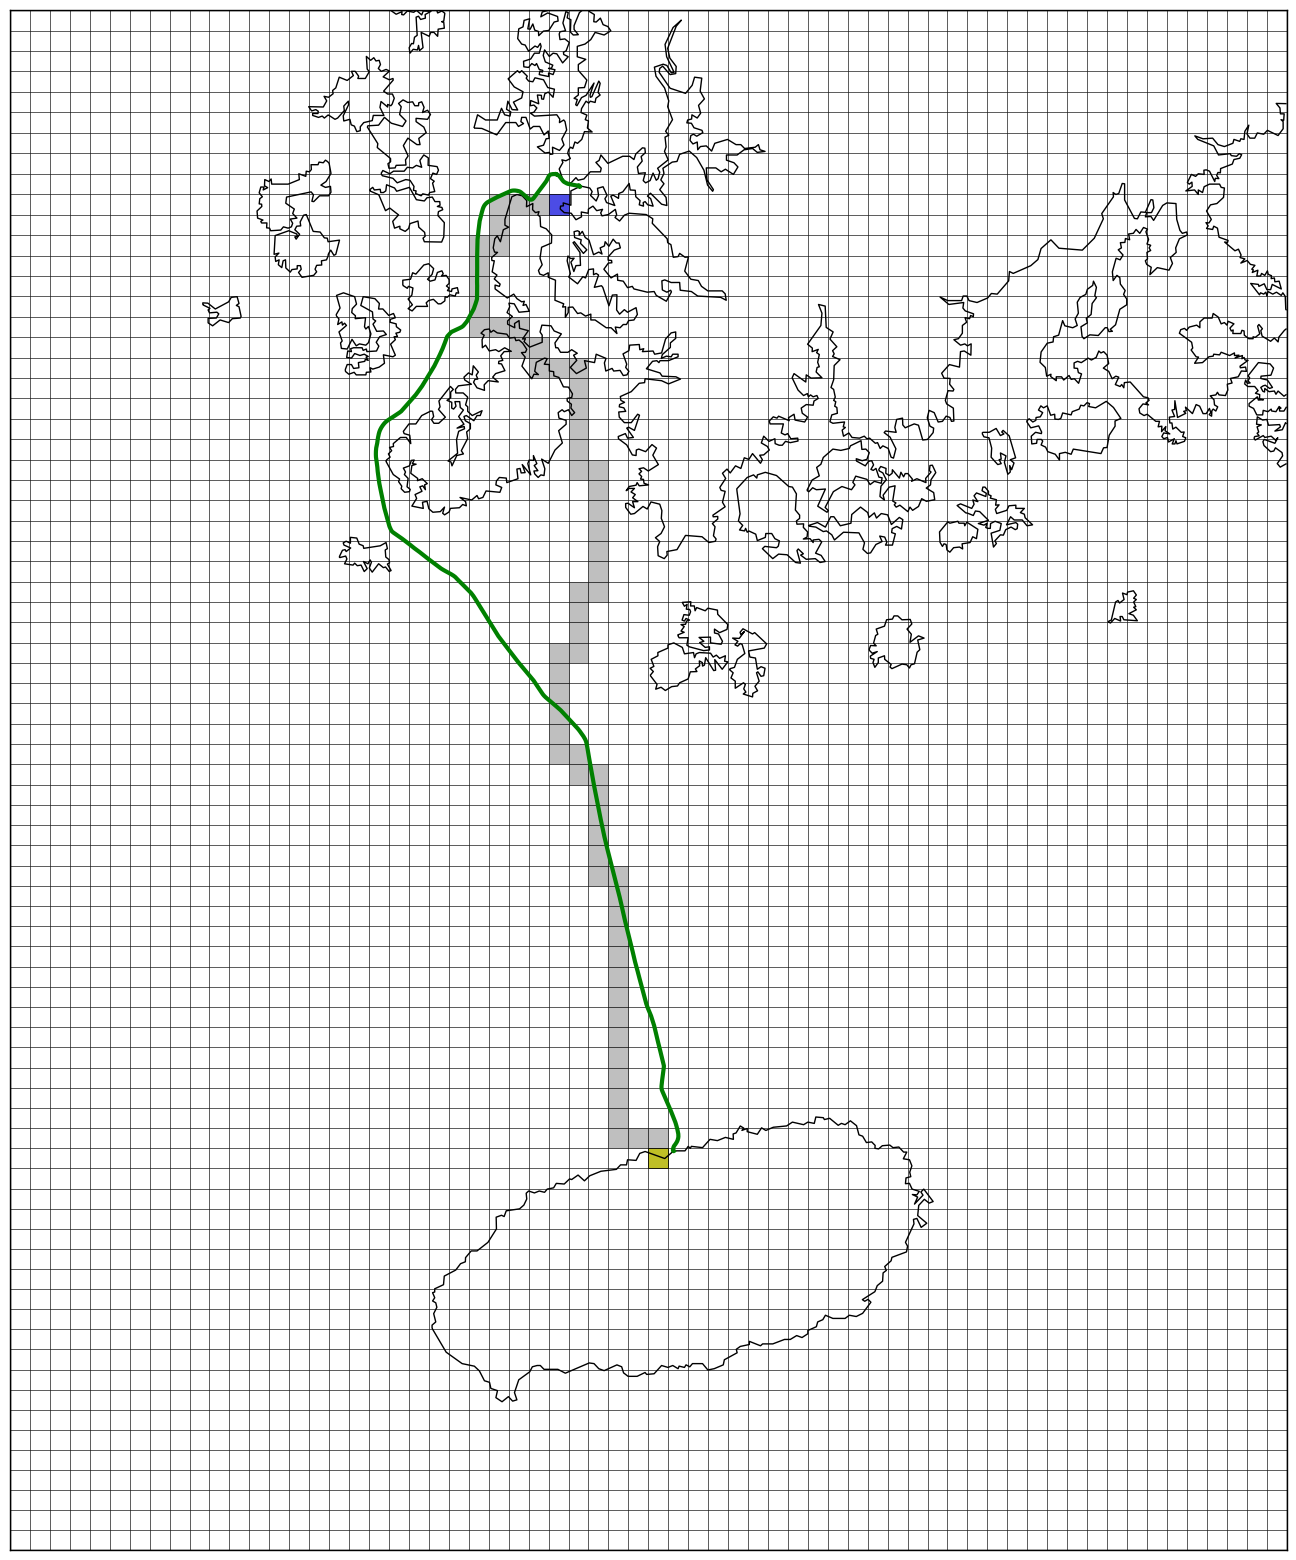

In [25]:
# 경로 1: 안전 50프로, 효율 50프로

f = plt.figure(figsize=[20, 20])
m = Basemap(llcrnrlon=base_lon[0], llcrnrlat=base_lat[0],
            urcrnrlon=base_lon[1], urcrnrlat=base_lat[1],
            resolution='h', projection='merc')
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary()
m.shadedrelief()

x, y = m(real_path_lons, real_path_lats)
m.plot(x, y, linewidth=3, color='g')

for ilon in range(1, len(grid_lon)):
    for ilat in range(1, len(grid_lat)):
        lats = [grid_lat[ilat-1], grid_lat[ilat], grid_lat[ilat], grid_lat[ilat-1]]
        lons = [grid_lon[ilon-1], grid_lon[ilon-1], grid_lon[ilon], grid_lon[ilon]]
        key = '(%f,%f,%d)'%(grid_lat[ilat-1], grid_lon[ilon-1], 0)
        if (ilat, ilon) not in minimal_path1:
            p = draw_basemap_grid(lats, lons, m, "none")
        else:
            p = draw_basemap_grid2(lats, lons, m, "grey", 0.5)

#출-도착지 시각화
lats = [grid_lat[start_lat-1], grid_lat[start_lat], grid_lat[start_lat], grid_lat[start_lat-1]]
lons = [grid_lon[start_lon-1], grid_lon[start_lon-1], grid_lon[start_lon], grid_lon[start_lon]]
p = draw_basemap_grid2(lats, lons, m, "b", 0.6)

lats = [grid_lat[end_lat-1], grid_lat[end_lat], grid_lat[end_lat], grid_lat[end_lat-1]]
lons = [grid_lon[end_lon-1], grid_lon[end_lon-1], grid_lon[end_lon], grid_lon[end_lon]]
p = draw_basemap_grid2(lats, lons, m, "y", 0.8)

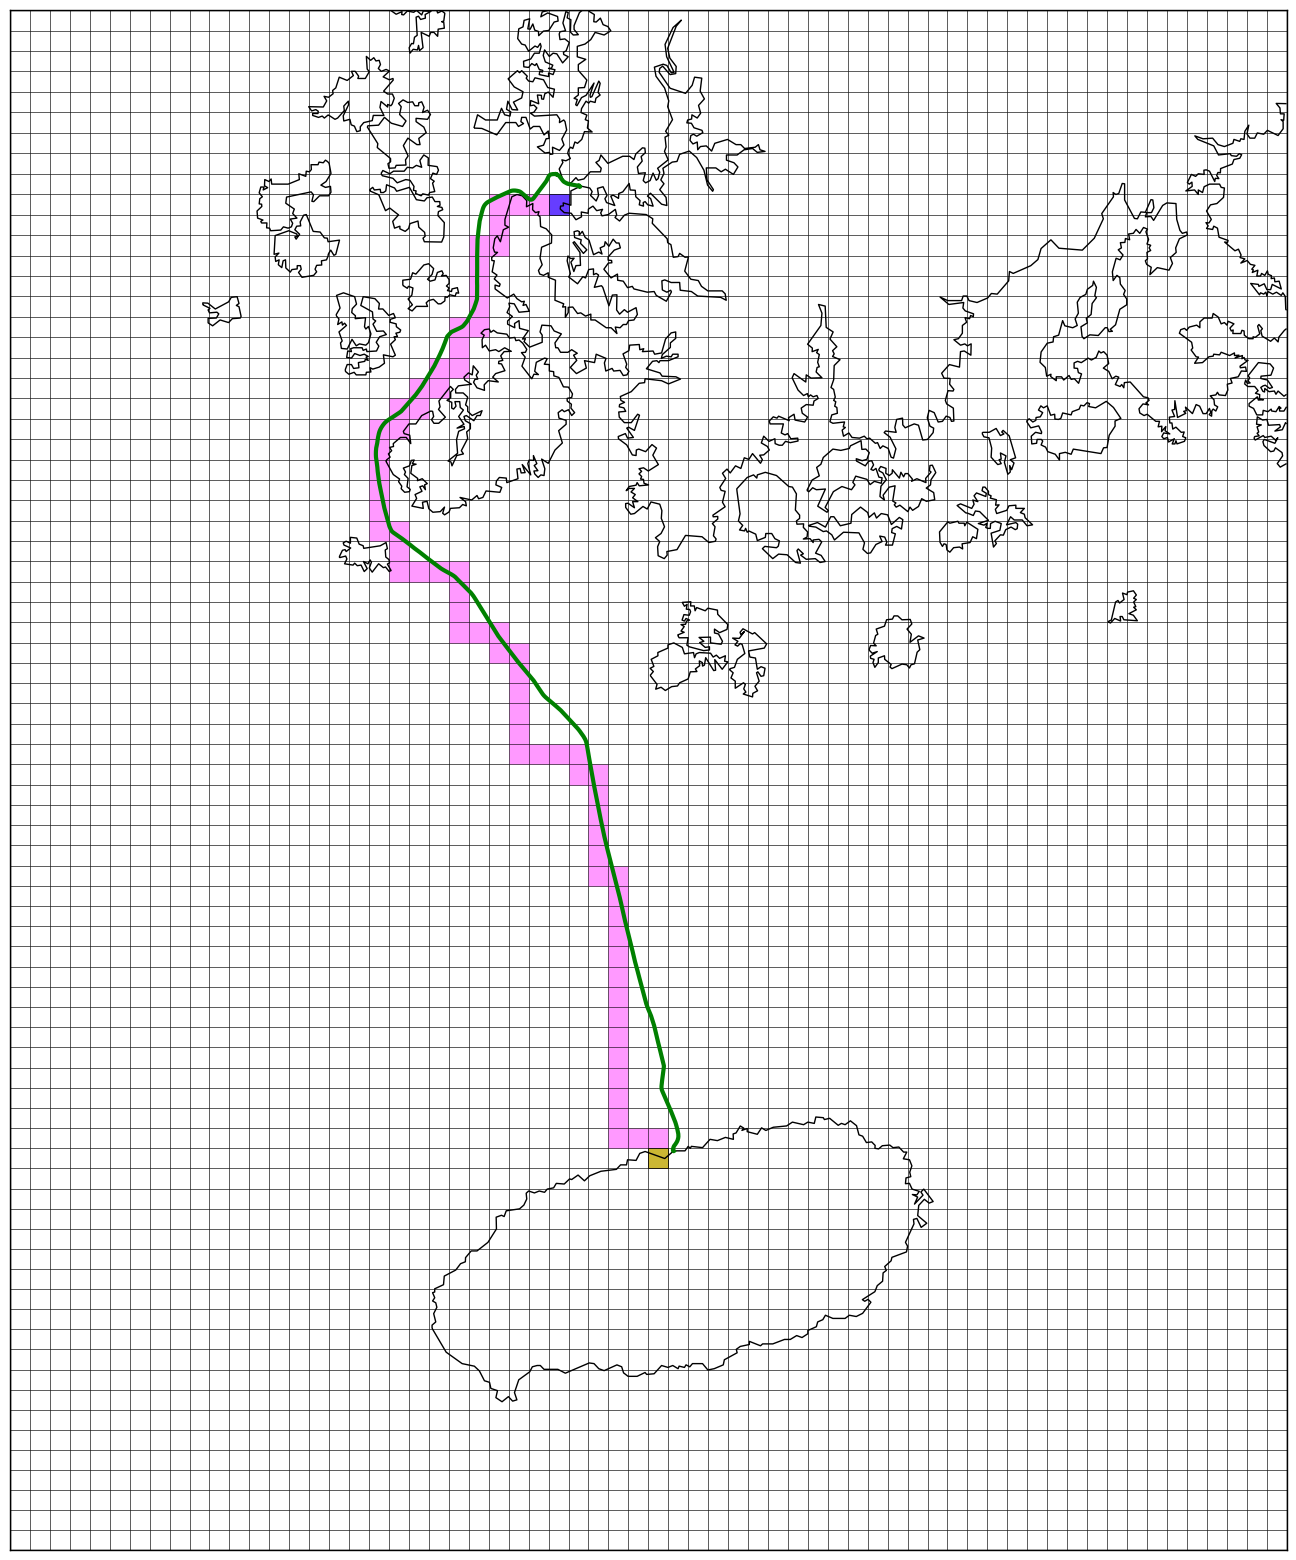

In [ ]:
# 경로 2: 안전 100프로
f = plt.figure(figsize=[20, 20])
m = Basemap(llcrnrlon=base_lon[0], llcrnrlat=base_lat[0],
            urcrnrlon=base_lon[1], urcrnrlat=base_lat[1],
            resolution='h', projection='merc')
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary()
m.shadedrelief()

x, y = m(real_path_lons, real_path_lats)
m.plot(x, y, linewidth=3, color='g')

for ilon in range(1, len(grid_lon)):
    for ilat in range(1, len(grid_lat)):
        lats = [grid_lat[ilat-1], grid_lat[ilat], grid_lat[ilat], grid_lat[ilat-1]]
        lons = [grid_lon[ilon-1], grid_lon[ilon-1], grid_lon[ilon], grid_lon[ilon]]
        key = '(%f,%f,%d)'%(grid_lat[ilat-1], grid_lon[ilon-1], 0)
        if (ilat, ilon) in minimal_path2:
            p = draw_basemap_grid2(lats, lons, m, "magenta", 0.4)
        else:
            p = draw_basemap_grid(lats, lons, m, "none")


#출-도착지 시각화
lats = [grid_lat[start_lat-1], grid_lat[start_lat], grid_lat[start_lat], grid_lat[start_lat-1]]
lons = [grid_lon[start_lon-1], grid_lon[start_lon-1], grid_lon[start_lon], grid_lon[start_lon]]
p = draw_basemap_grid2(lats, lons, m, "b", 0.6)

lats = [grid_lat[end_lat-1], grid_lat[end_lat], grid_lat[end_lat], grid_lat[end_lat-1]]
lons = [grid_lon[end_lon-1], grid_lon[end_lon-1], grid_lon[end_lon], grid_lon[end_lon]]
p = draw_basemap_grid2(lats, lons, m, "y", 0.8)

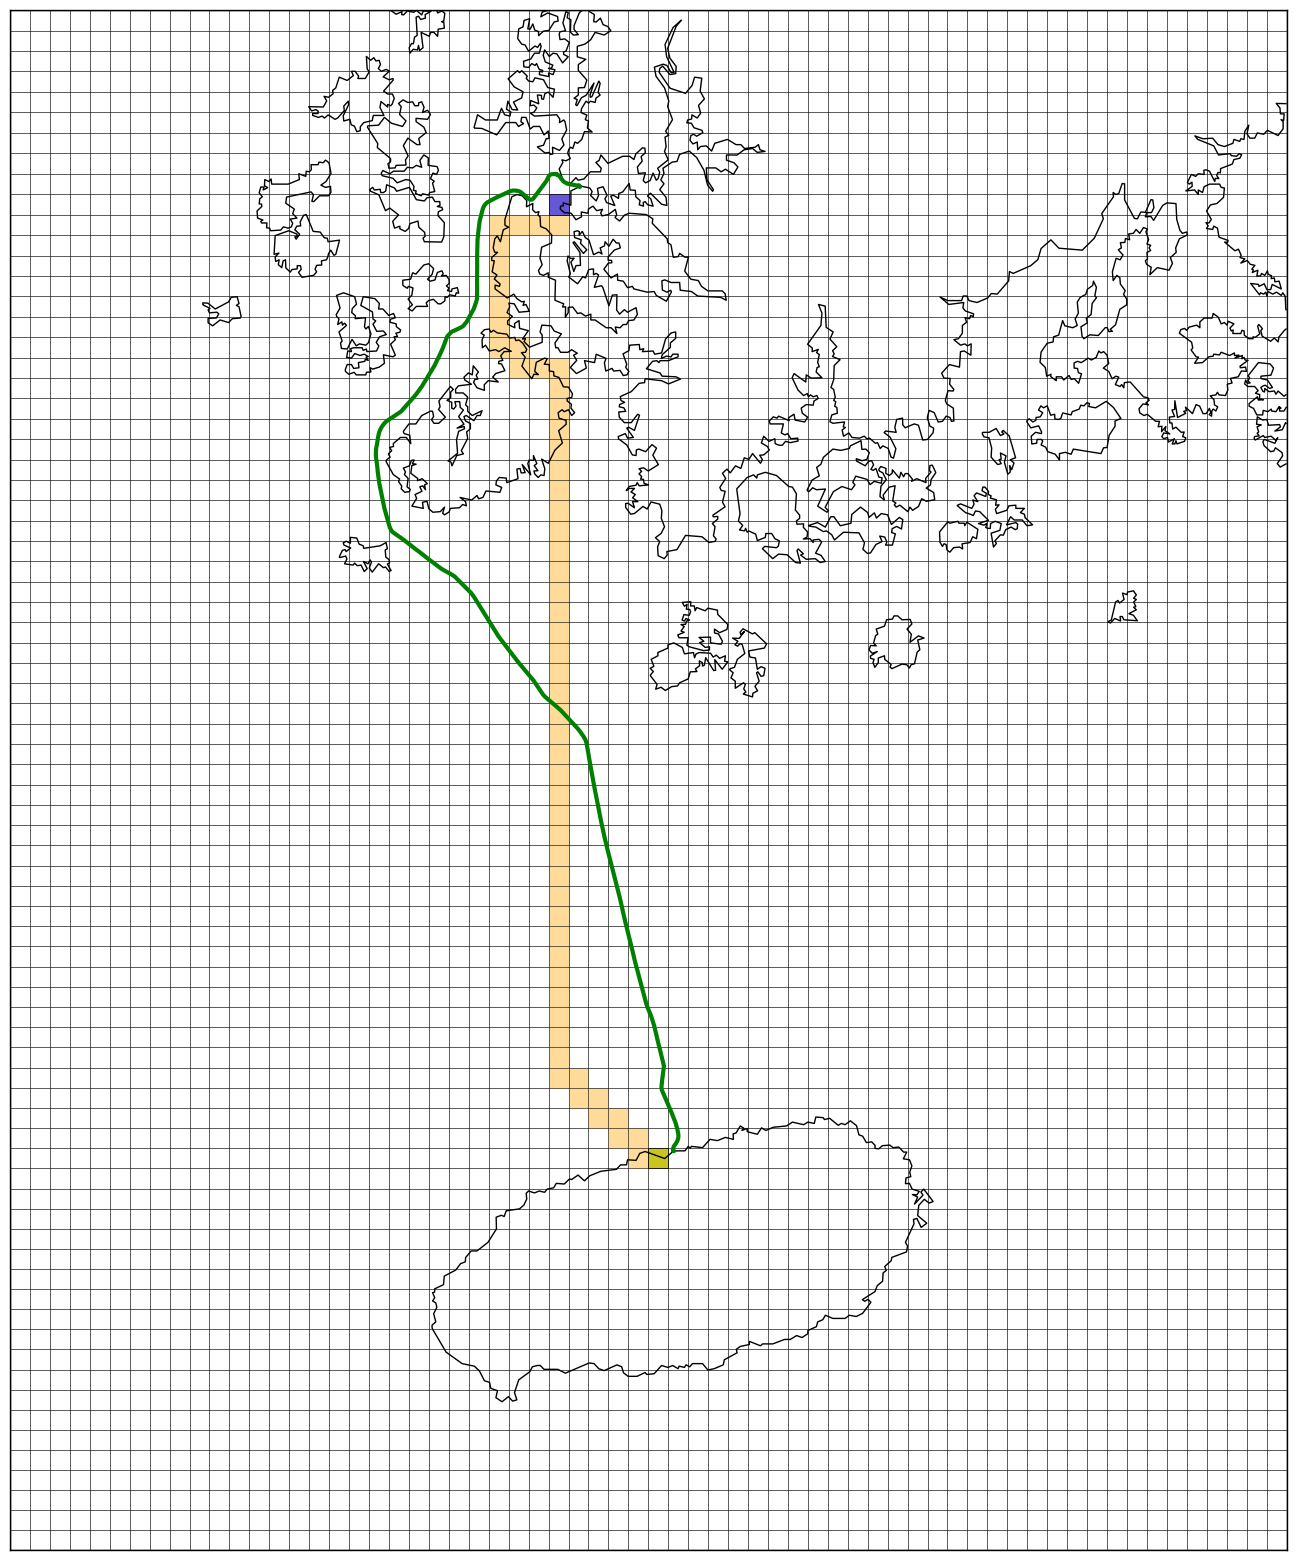

In [ ]:
# 경로 3: 효율 100프로

f = plt.figure(figsize=[20, 20])
m = Basemap(llcrnrlon=base_lon[0], llcrnrlat=base_lat[0],
            urcrnrlon=base_lon[1], urcrnrlat=base_lat[1],
            resolution='h', projection='merc')
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary()
m.shadedrelief()

x, y = m(real_path_lons, real_path_lats)
m.plot(x, y, linewidth=3, color='g')

for ilon in range(1, len(grid_lon)):
    for ilat in range(1, len(grid_lat)):
        lats = [grid_lat[ilat-1], grid_lat[ilat], grid_lat[ilat], grid_lat[ilat-1]]
        lons = [grid_lon[ilon-1], grid_lon[ilon-1], grid_lon[ilon], grid_lon[ilon]]
        key = '(%f,%f,%d)'%(grid_lat[ilat-1], grid_lon[ilon-1], 0)
        if (ilat, ilon) in minimal_path3:
            p = draw_basemap_grid2(lats, lons, m, "orange", 0.4)
        else:
            p = draw_basemap_grid(lats, lons, m, "none")


#출-도착지 시각화
lats = [grid_lat[start_lat-1], grid_lat[start_lat], grid_lat[start_lat], grid_lat[start_lat-1]]
lons = [grid_lon[start_lon-1], grid_lon[start_lon-1], grid_lon[start_lon], grid_lon[start_lon]]
p = draw_basemap_grid2(lats, lons, m, "b", 0.6)

lats = [grid_lat[end_lat-1], grid_lat[end_lat], grid_lat[end_lat], grid_lat[end_lat-1]]
lons = [grid_lon[end_lon-1], grid_lon[end_lon-1], grid_lon[end_lon], grid_lon[end_lon]]
p = draw_basemap_grid2(lats, lons, m, "y", 0.8)